## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [2]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [5]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2024-12-16 18:36:19--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2024-12-16 18:36:20 (10.0 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [7]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [8]:
token_to_id = {char: idx for idx, char in enumerate(tokens)}
id_to_token = {idx: char for char, idx in token_to_id.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

def train_rnn(model, data_loader, criterion, optimizer, num_epochs):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            hidden = model.init_hidden(inputs.size(0))
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        loss_list.append(avg_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')
    return model, loss_list


def prepare_data(token_to_id, id_to_token, text, seq_length = 25):

    inputs = []
    targets = []

    for i in range(len(text) - seq_length):
        seq = text[i:i + seq_length]
        label = text[i + seq_length]
        inputs.append([token_to_id[char] for char in seq])
        targets.append(token_to_id[label])

    inputs_tensor = torch.tensor(inputs, dtype=torch.long)
    targets_tensor = torch.tensor(targets, dtype=torch.long)

    inputs_one_hot = torch.zeros(inputs_tensor.size(0), inputs_tensor.size(1), len(token_to_id), dtype=torch.float32)


    for i in range(inputs_tensor.size(0)):
        inputs_one_hot[i].scatter_(1, inputs_tensor[i].unsqueeze(1), 1.0)

    for i in range(inputs_tensor.size(0)):
        inputs_one_hot[i].scatter_(1, inputs_tensor[i].unsqueeze(1).long(), 1.0)

    return inputs_one_hot, targets_tensor


In [13]:
inputs_tensor, targets_tensor = prepare_data(token_to_id, id_to_token, text)
input_size = len(token_to_id)
hidden_size = 128
output_size = len(token_to_id)
num_epochs = 30
learning_rate = 0.001


model = CharRNN(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

dataset = torch.utils.data.TensorDataset(inputs_tensor, targets_tensor)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

model, loss_list = train_rnn(model, data_loader, loss, opt, num_epochs)

Epoch 1/30, Loss: 2.6254
Epoch 2/30, Loss: 2.3515
Epoch 3/30, Loss: 2.2519
Epoch 4/30, Loss: 2.1887
Epoch 5/30, Loss: 2.1404
Epoch 6/30, Loss: 2.0973
Epoch 7/30, Loss: 2.0686
Epoch 8/30, Loss: 2.0384
Epoch 9/30, Loss: 2.0176
Epoch 10/30, Loss: 1.9967
Epoch 11/30, Loss: 1.9792
Epoch 12/30, Loss: 1.9651
Epoch 13/30, Loss: 1.9495
Epoch 14/30, Loss: 1.9403
Epoch 15/30, Loss: 1.9253
Epoch 16/30, Loss: 1.9160
Epoch 17/30, Loss: 1.9106
Epoch 18/30, Loss: 1.9071
Epoch 19/30, Loss: 1.8911
Epoch 20/30, Loss: 1.8875
Epoch 21/30, Loss: 1.8800
Epoch 22/30, Loss: 1.8792
Epoch 23/30, Loss: 1.8692
Epoch 24/30, Loss: 1.8663
Epoch 25/30, Loss: 1.8617
Epoch 26/30, Loss: 1.8664
Epoch 27/30, Loss: 1.8551
Epoch 28/30, Loss: 1.8537
Epoch 29/30, Loss: 1.8525
Epoch 30/30, Loss: 1.8477


Plot the loss function (axis X: number of epochs, axis Y: loss function).

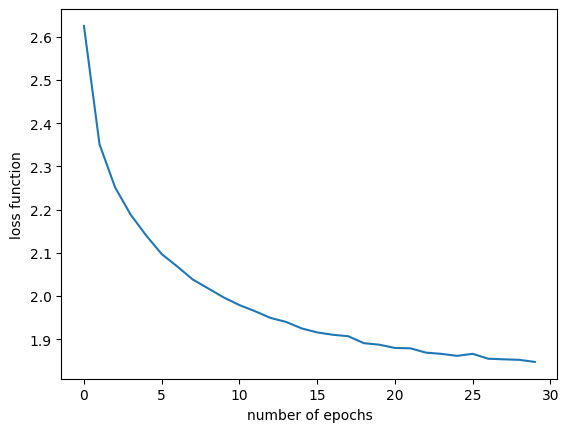

In [14]:
import matplotlib.pyplot as plt

def make_loss_plot(loss_list):
    plt.plot(loss_list)
    plt.ylabel('loss function')
    plt.xlabel('number of epochs')
    plt.show()
    return
make_loss_plot(loss_list)

In [165]:
import numpy as np
def generate_sample(char_rnn, seed_phrase='Как прекрасен может быть мир, когда мы открываем свои сердца для любви и доброты', length=150, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    seed_phrase = seed_phrase.lower()
    inputs_one_hot, _ = prepare_data(token_to_id, id_to_token, seed_phrase, seq_length=25)
    dataset = torch.utils.data.TensorDataset(inputs_one_hot)
    test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    hidden = char_rnn.init_hidden(batch_size=1)
    с = char_rnn.init_c(batch_size=1)
    print(hidden.size())
    char_rnn.eval()

    with torch.no_grad():
    #feed the seed phrase, if any
      for inputs_tensor in test_data_loader:
          outputs, hidden, c = char_rnn(inputs_tensor[0], hidden, с)

      #start generating
      for _ in range(length - len(seed_phrase)):
          if inputs_tensor[-1].size(0) != 1:
            inp = inputs_tensor[-1].unsqueeze(0)
          else:
            inp = inputs_tensor[-1]
          outputs, hidden, с = char_rnn(inp, hidden, с)
          p_next = nn.functional.softmax(outputs / temperature, dim=-1).data.numpy()[0]

          # sample next token and push it back into x_sequence
          next_ix = np.random.choice(len(tokens), p=p_next)
          seed_phrase = seed_phrase + id_to_token[next_ix]
          inputs_tensor, _ = prepare_data(token_to_id, id_to_token, seed_phrase, seq_length=25)

    return seed_phrase

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [11]:
class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, c):
        out, (hidden, c) = self.rnn(x, (hidden, c))
        out = self.fc(out[:, -1, :])
        return out, hidden, c

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

    def init_c(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

In [13]:
def train_lstm(model, data_loader, criterion, optimizer, num_epochs):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            hidden = model.init_hidden(inputs.size(0))
            c = model.init_c(inputs.size(0))
            outputs, hidden, c = model(inputs, hidden, c)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        loss_list.append(avg_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')
    return model, loss_list

In [153]:
inputs_tensor, targets_tensor = prepare_data(token_to_id, id_to_token, text, seq_length=25)
input_size = len(token_to_id)
hidden_size = 128
output_size = len(token_to_id)
num_epochs = 30
learning_rate = 0.001


model = CharLSTM(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

dataset = torch.utils.data.TensorDataset(inputs_tensor, targets_tensor)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

model, loss_list = train_lstm(model, data_loader, loss, opt, num_epochs)

Epoch 1/30, Loss: 2.6455
Epoch 2/30, Loss: 2.2822
Epoch 3/30, Loss: 2.1531
Epoch 4/30, Loss: 2.0603
Epoch 5/30, Loss: 1.9874
Epoch 6/30, Loss: 1.9263
Epoch 7/30, Loss: 1.8730
Epoch 8/30, Loss: 1.8257
Epoch 9/30, Loss: 1.7847
Epoch 10/30, Loss: 1.7469
Epoch 11/30, Loss: 1.7146
Epoch 12/30, Loss: 1.6839
Epoch 13/30, Loss: 1.6556
Epoch 14/30, Loss: 1.6290
Epoch 15/30, Loss: 1.6057
Epoch 16/30, Loss: 1.5818
Epoch 17/30, Loss: 1.5606
Epoch 18/30, Loss: 1.5408
Epoch 19/30, Loss: 1.5227
Epoch 20/30, Loss: 1.5044
Epoch 21/30, Loss: 1.4876
Epoch 22/30, Loss: 1.4718
Epoch 23/30, Loss: 1.4570
Epoch 24/30, Loss: 1.4417
Epoch 25/30, Loss: 1.4287
Epoch 26/30, Loss: 1.4158
Epoch 27/30, Loss: 1.4040
Epoch 28/30, Loss: 1.3923
Epoch 29/30, Loss: 1.3817
Epoch 30/30, Loss: 1.3741


Plot the loss function of the number of epochs. Does the final loss become better?

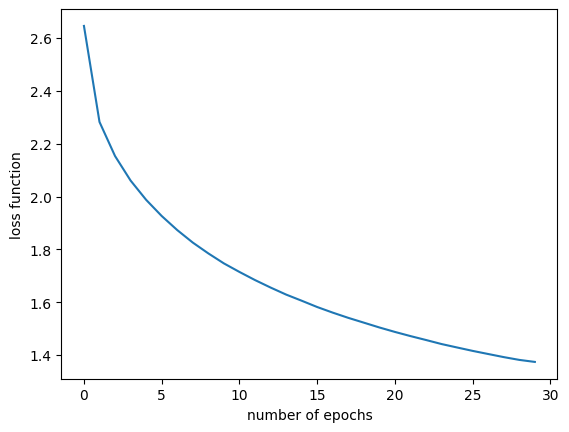

In [154]:
make_loss_plot(loss_list)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [170]:
print(generate_sample(model, length=200, temperature=0.1))

torch.Size([1, 1, 128])
как прекрасен может быть мир, когда мы открываем свои сердца для любви и добротыи,м
анвеерн ов лнео цсвеалк ор кноовн
оисткроейй,с
ьв отнъоедтиалн
ыи
 нвеедц ыу  сдтерльан ообтрраемт
ьс твоорч авлиецт


В LSTM меньше выражена проблема затухания градиентов за счет памяти, гейтов и т.д. Нужно дольше обучать, чтобы получить лучше генерацию

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [18]:
# Saving and loading code here
torch.save(model.state_dict(), 'charlstm.pt')


model = CharLSTM(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('charlstm.pt', weights_only=True))

<All keys matched successfully>

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)